# 텍스트 분류 (트위터단어분류+검토결과예측) : 샘플링방식변경

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
from konlpy.tag import Okt, Kkma, Mecab, Hannanum
Okt = Okt()
kkma = Kkma()
hannanum = Hannanum()

In [3]:
df = pd.read_csv('new_data_8529.csv', sep='\t', encoding='UTF-8')

In [4]:
df.head(3)

std_clm_type_cd  ro_y  clm_jgmt_dt ceq_caus_cd ceq_psit_cd    ceq_psit_nm  \
0               W  2017     20170811         ZZ7         B11  조립 문제_미장착/오장착   
1               W  2018     20180822         ZZ7         B11  조립 문제_미장착/오장착   
2               W  2018     20181006         ZZ5         B11  조립 문제_미장착/오장착   

  trim_plnt_cd prj_vehl_cd mdl_cd part_sys_cd repn_part_cd  \
0         KV11          CK     J5          TT        82305   
1         KV11          YP     A9          TT        84211   
2         KV11          YP     A9          TT        83912   

                                        clm_prtl_sbc 대상 선정   구분  책임구   원인  \
0  [C] 1.현상:엔진룸 다량의 연료 누유 발생.2.점검:엔진룸 다량의 연료 누유 점...     X  NaN  NaN  NaN   
1                       [C] 1.현상: 리어 도어 앤티 취핑 필림 미장착     X  NaN  NaN  NaN   
2  [C] 1.현상:Rr RH 커튼 후크  미장착 출고됨.2.조치내용:Rr RH 커튼 ...     X  NaN  NaN  NaN   

   검토결과  
0  X---  
1  X---  
2  X---

In [5]:
df.shape

(8529, 17)

# 분류현황

In [6]:
category_count = df['대상 선정'].value_counts()
category_count

X    5517
O    3012
Name: 대상 선정, dtype: int64

In [7]:
category_count = df['구분'].value_counts()
category_count

기능(커넥터)    1601
실내부품이음     1050
하체이음        361
Name: 구분, dtype: int64

In [8]:
category_count = df['책임구'].value_counts()
category_count

구매      2274
생산공장     724
연구소       14
Name: 책임구, dtype: int64

In [9]:
category_count = df['원인'].value_counts()
category_count

부품       2274
조립불량      230
결선불량      225
체결불량      103
기타        100
미결선        37
이종/간섭      21
설계/구조      14
이물          8
Name: 원인, dtype: int64

# ◈ Null 제거

In [10]:
df_bak = df.copy()

In [11]:
# 제거
# df = df[df['대상 선정'].notnull()].copy()
# 다른값으로 채우기
df = df.fillna('N')

In [12]:
df.shape

(8529, 17)

In [13]:
category_count = df['대상 선정'].value_counts()
category_count

X    5517
O    3012
Name: 대상 선정, dtype: int64

In [14]:
category_count = df['구분'].value_counts()
category_count

N          5517
기능(커넥터)    1601
실내부품이음     1050
하체이음        361
Name: 구분, dtype: int64

In [15]:
category_count = df['책임구'].value_counts()
category_count

N       5517
구매      2274
생산공장     724
연구소       14
Name: 책임구, dtype: int64

In [16]:
category_count = df['원인'].value_counts()
category_count

N        5517
부품       2274
조립불량      230
결선불량      225
체결불량      103
기타        100
미결선        37
이종/간섭      21
설계/구조      14
이물          8
Name: 원인, dtype: int64

In [17]:
category_count = df['검토결과'].value_counts()
category_count

X---                    5517
O-기능(커넥터)-구매-부품         1288
O-실내부품이음-구매-부품           737
O-하체이음-구매-부품             249
O-기능(커넥터)-생산공장-결선불량      225
O-실내부품이음-생산공장-조립불량       204
O-실내부품이음-생산공장-체결불량        70
O-하체이음-생산공장-기타            53
O-기능(커넥터)-생산공장-미결선        37
O-하체이음-생산공장-체결불량          33
O-기능(커넥터)-생산공장-기타         30
O-하체이음-생산공장-조립불량          26
O-기능(커넥터)-생산공장-이종/간섭      21
O-실내부품이음-생산공장-기타          17
O-실내부품이음-연구소-설계/구조        14
O-실내부품이음-생산공장-이물           8
Name: 검토결과, dtype: int64

# 전처리

In [18]:
# 예측값과 실제값 비교를 위해 컬럼을 하나 더 생성합니다.
df['result_pred'] = df['검토결과'].astype(str).copy()

In [19]:
category_count = df['result_pred'].value_counts()
category_count

X---                    5517
O-기능(커넥터)-구매-부품         1288
O-실내부품이음-구매-부품           737
O-하체이음-구매-부품             249
O-기능(커넥터)-생산공장-결선불량      225
O-실내부품이음-생산공장-조립불량       204
O-실내부품이음-생산공장-체결불량        70
O-하체이음-생산공장-기타            53
O-기능(커넥터)-생산공장-미결선        37
O-하체이음-생산공장-체결불량          33
O-기능(커넥터)-생산공장-기타         30
O-하체이음-생산공장-조립불량          26
O-기능(커넥터)-생산공장-이종/간섭      21
O-실내부품이음-생산공장-기타          17
O-실내부품이음-연구소-설계/구조        14
O-실내부품이음-생산공장-이물           8
Name: result_pred, dtype: int64

In [20]:
#명사 추출 함수
def nounextract(text):
    text = Okt.nouns(text)
    return text

In [21]:
df['clm_prtl_sbc'] = df['clm_prtl_sbc'].apply(nounextract)

In [22]:
def preprocessing(text):
    text= str(text)
    text = re.sub('\\\\n', ' ', text)
    text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)   #-> 특수문자 제거
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)         #-> 한글, 영문, 숫자만 남기고 모두 제거
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)              #-> 한글, 영문만 남기고 모두 제거
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ]', ' ', text)              #-> 한글만 남기고 모두 제거
    return text

In [23]:
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['현상', '[C]','현상및점검','현    상','현 상','점검점검','점검내용','조치내용','점검점검내용','현상및조치','C','원인',
             '점검/원인','사진첨부','(사진첨부)','사진참조','점검및원인','동영상참조','동영상','대리점','고객','고객에게','상기',
             '차량','상기차량은','자동차','당차량은','당차량','당','차량은','점검및조치내용','F/LH','F/RH','L/H','R/H','L/H리어',
             'R/H리어','LH/RH','LH','RH','(RH)','(LH)','R/LH','R/RH','리어RH','리어LH','LH쪽','RH쪽','Rr','RR','FRT','Frt',
             'frt','rr','C-10000','C-100','(좌)','(우)','A/S']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)    

In [24]:
%time df['clm_prtl_sbc'] = df['clm_prtl_sbc'].apply(preprocessing)

Wall time: 293 ms


In [25]:
df['clm_prtl_sbc'].head(10)

0     현상 엔진 룸 다량 연료 누유 발생 점검 엔진 룸 다량 연료 누유 점검 점검 내용...
1                               현상 리 도어 앤티 취핑 필림 미장 착 
2               현상 커튼 후크 미장 착 출고 조치 내용 커튼 후크 장착후 출고 함 
3                     현상 및 조치 차량 웨 스트립 고무 주름 발생 교환 조치 
4                           몰딩 내부 고무 미조 립 상태 몰딩 조립 출고 
5     현상 리 윈도우 판넬 트립 미장 착 내용 차량 출고 후 리 윈도우 판넬 트립 좌측...
6                       우측 슬라이딩 도어 커튼 도리 창작 장착 후 출고 함 
7     현상 프론트 우측 도어 웨져스터립 부착 상태 출고 조치 내용 웨져 스트립 부착 후...
8     현상 수석 부분 누수 점검 내용 및 원인 누수 테스트 기 확인 시 위 에어컨 스위...
9     현 상 리 어도 휀더부 불만 점검 내용 점검 결과 취핑 테이프 내부 물질 과 유입...
Name: clm_prtl_sbc, dtype: object

In [26]:
%time df['clm_prtl_sbc'] = df['clm_prtl_sbc'].apply(remove_stopwords)

Wall time: 216 ms


In [27]:
df['clm_prtl_sbc'].head(10)

0     엔진 룸 다량 연료 누유 발생 점검 엔진 룸 다량 연료 누유 점검 점검 내용 엔진...
1                                  리 도어 앤티 취핑 필림 미장 착 
2                  커튼 후크 미장 착 출고 조치 내용 커튼 후크 장착후 출고 함 
3                           및 조치 웨 스트립 고무 주름 발생 교환 조치 
4                           몰딩 내부 고무 미조 립 상태 몰딩 조립 출고 
5     리 윈도우 판넬 트립 미장 착 내용 출고 후 리 윈도우 판넬 트립 좌측 미장 착 ...
6                       우측 슬라이딩 도어 커튼 도리 창작 장착 후 출고 함 
7     프론트 우측 도어 웨져스터립 부착 상태 출고 조치 내용 웨져 스트립 부착 후 출고 함 
8     수석 부분 누수 점검 내용 및 누수 테스트 기 확인 시 위 에어컨 스위치 쪽 물이...
9     현 상 리 어도 휀더부 불만 점검 내용 점검 결과 취핑 테이프 내부 물질 과 유입...
Name: clm_prtl_sbc, dtype: object

# ◈ Train Data & Test Data 만들기 (행추출 랜덤 샘플링)

In [28]:
df = df.reindex()

In [29]:
df.shape

(8529, 18)

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
df_train_v,df_test_v = train_test_split(df, test_size = 0.1, random_state=123)

In [32]:
df_train = df_train_v.copy()
df_test = df_test_v.copy()

In [33]:
df_train.shape

(7676, 18)

In [34]:
df_test.shape

(853, 18)

# ◈ 단어 벡터화

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
stops = ['C','현상','조치']
vectorizer = CountVectorizer(analyzer = 'word',    # 캐릭터 단위로도 벡터화가능
                             tokenizer = None,     # 토크나이저를 따로 지정해 줄 수도 있음
                             preprocessor = None,  # 전처리 도구
                             stop_words = stops,   # 불용어 nltk등의 도구를 사용할 수도 있음
                             min_df = 1,           # 토큰출현 최소문서개수:오타 및 자주 출현 안하는 특수전문용어 제거에 좋음
                             ngram_range=(1, 3),   # BOW단위를 1~3개로 지정
                             max_features = 20000  # 만들 피처수, 단어수가 됨
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=1,
        ngram_range=(1, 3), preprocessor=None,
        stop_words=['C', '현상', '조치'], strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

In [36]:
%%time
train_feature_vector = vectorizer.fit_transform(df_train['clm_prtl_sbc'])
train_feature_vector.shape

Wall time: 949 ms


In [37]:
train_feature_vector.toarray().transpose()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [38]:
%%time
test_feature_vector = vectorizer.fit_transform(df_test['clm_prtl_sbc'])
test_feature_vector.shape

Wall time: 139 ms


In [39]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

20000


['가감',
 '가감 실내',
 '가감 실내 대쉬보드',
 '가감 저속',
 '가감 저속 등판',
 '가끔',
 '가끔 소음',
 '가끔 소음 허브',
 '가끔 재현',
 '가끔 재현 발생']

In [40]:
dist = np.sum(train_feature_vector, axis=0)
dist.shape

(1, 20000)

In [41]:
dist_pd = pd.DataFrame(dist, columns=vocab)
dist_pd

가감  가감 실내  가감 실내 대쉬보드  가감 저속  가감 저속 등판  가끔  가끔 소음  가끔 소음 허브  가끔 재현  \
0   5     10           3      5         3  15      4         4    199   

   가끔 재현 발생    ...     힌지 볼트  힌지 볼트 볼트  힌지 부위  힌지 부위 수석  힌지 스톱  힌지 스톱 볼트  \
0         4    ...         3         9      5         5      6        38   

   힌지 스트라이크  힌지 스트라이크 조정  힌지 조정  힌지 조정 작업  
0         3            3      5         5  

[1 rows x 20000 columns]

In [43]:
dist_pd_t = dist_pd.T
dist_pd_t.head(10)

0
가감            5
가감 실내        10
가감 실내 대쉬보드    3
가감 저속         5
가감 저속 등판      3
가끔           15
가끔 소음         4
가끔 소음 허브      4
가끔 재현       199
가끔 재현 발생      4

In [44]:
a = dist_pd_t.sort_values(by=0, ascending = False)
a.head(10)

0
제기 냄새 장건  7488
반도        7204
고무 점검 웨져  5248
수회        4279
부위 그득     3921
확인 이상 현재  3550
다닥 소음     3440
스캐너       2529
직후 소음 발생  2115
교환 불량     2080

In [45]:
a.plot()

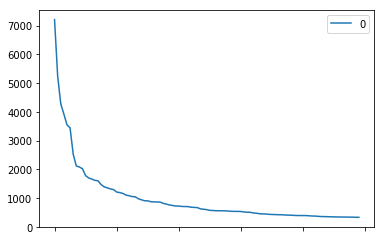

In [46]:
b = a.iloc[1:100, :]
b.plot()

# ◈ tf-idf 가중치 적용하기

In [47]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer (smooth_idf = False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [48]:
%%time
train_feature_tfidf = transformer.fit_transform (train_feature_vector)
train_feature_tfidf.shape

Wall time: 55 ms


In [49]:
%%time
test_feature_tfidf = transformer.fit_transform (test_feature_vector)
test_feature_tfidf.shape

Wall time: 101 ms


# ◈ Machine Learning

In [50]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier (
    n_estimators = 100, n_jobs = -1, random_state = 2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [51]:
y_label = df_train['result_pred']
%time forest = forest.fit (train_feature_tfidf, y_label)

Wall time: 1.98 s


# ◈ Model 평가

In [52]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold (n_splits = 5, shuffle = True, random_state = 0)

scoring = 'accuracy'
%time score = cross_val_score (forest, train_feature_vector, y_label, cv = k_fold, n_jobs = -1, scoring = scoring)
score

Wall time: 30 s


array([0.74088542, 0.74006515, 0.75114007, 0.77068404, 0.7465798 ])

In [53]:
round (np.mean(score)*100,1)

75.0

# ◈ 예측 (Test Data 이용)

In [54]:
y_predict = forest.predict(test_feature_vector)
y_predict[:3]

array(['X---', 'X---', 'X---'], dtype=object)

In [55]:
y_predict.shape

(853,)

In [56]:
output = pd.DataFrame (data = {'test_result_pred':y_predict})
output.head()

test_result_pred
0             X---
1             X---
2             X---
3             X---
4             X---

In [57]:
df_test ['test_result_pred'] = y_predict

In [58]:
df_test.head(3)

std_clm_type_cd  ro_y  clm_jgmt_dt ceq_caus_cd ceq_psit_cd   ceq_psit_nm  \
8400               W  2015     20151214         ZZ3         V91  차체 진동/떨림_주행중   
2485               W  2015     20150629         ZZ4         I11     작동불량_작동안됨   
6990               W  2017     20170329         ZZ5         Q55     소음/이음_주행중   

     trim_plnt_cd prj_vehl_cd mdl_cd part_sys_cd repn_part_cd  \
8400         KV11          KH     DH          CC        52910   
2485         KV11          YP     A9          AC        96985   
6990         KV11          YP     A9          CC        58250   

                                           clm_prtl_sbc 대상 선정       구분 책임구  \
8400   주행 핸들 타이어 바 란스 점검 바 란스 점검 시 그 바 란스 바 란스 점검 조정...     X        N   N   
2485   클러스터 온도 표시 불량 점검 하니 배선 커넥터 정상 학인 온도 센서 품질 불량 ...     O  기능(커넥터)  구매   
6990   주행 소음 점검 내용 및 주행 뜨드득 소음 발생 및 후진 시 브레이크 점검 좌측 ...     O     하체이음  구매   

      원인             검토결과      result_pred test_result_pred  
8400   N             X---             X---             X---  
2485  부품  O-기능(커넥터)-구매-부품  O-기능(커넥터)-구매-부품             X---  
6990  부품     O-하체이음-구매-부품     O-하체이음-구매-부품             X---

# ◈ 결과검증

In [59]:
df_test ['predict_diff'] = 0
df_test ['predict_diff'] = (df_test['검토결과'] == df_test['test_result_pred']) == 1
df_test['predict_diff'] = df_test['predict_diff'].astype(int)
df_test.head(3)

std_clm_type_cd  ro_y  clm_jgmt_dt ceq_caus_cd ceq_psit_cd   ceq_psit_nm  \
8400               W  2015     20151214         ZZ3         V91  차체 진동/떨림_주행중   
2485               W  2015     20150629         ZZ4         I11     작동불량_작동안됨   
6990               W  2017     20170329         ZZ5         Q55     소음/이음_주행중   

     trim_plnt_cd prj_vehl_cd mdl_cd part_sys_cd repn_part_cd  \
8400         KV11          KH     DH          CC        52910   
2485         KV11          YP     A9          AC        96985   
6990         KV11          YP     A9          CC        58250   

                                           clm_prtl_sbc 대상 선정       구분 책임구  \
8400   주행 핸들 타이어 바 란스 점검 바 란스 점검 시 그 바 란스 바 란스 점검 조정...     X        N   N   
2485   클러스터 온도 표시 불량 점검 하니 배선 커넥터 정상 학인 온도 센서 품질 불량 ...     O  기능(커넥터)  구매   
6990   주행 소음 점검 내용 및 주행 뜨드득 소음 발생 및 후진 시 브레이크 점검 좌측 ...     O     하체이음  구매   

      원인             검토결과      result_pred test_result_pred  predict_diff  
8400   N             X---             X---             X---             1  
2485  부품  O-기능(커넥터)-구매-부품  O-기능(커넥터)-구매-부품             X---             0  
6990  부품     O-하체이음-구매-부품     O-하체이음-구매-부품             X---             0

In [60]:
diff_sum = df_test['predict_diff'].sum()
diff_sum

534

In [61]:
y_predict_len = len(y_predict)
y_predict_len

853

# ◈ 정확도

In [62]:
Acy = round(diff_sum/y_predict_len*100,1)
Acy

62.6